# 1. Read and parse dataset: 20 News groups and Reuters news 

Here, I read and parsed both data sets and cleaned texts with stop words deletion. 

### 1.1 reading/parsing 20 Newsgroup data 

In [1]:
# newsgroup 20 
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(shuffle=True, subset='all', remove=('headers', 'footers', 'quetes'))

In [2]:
print("Number of articles : ",len(newsgroups.data)) # total num of data
print("Number of different categories : ", len(newsgroups.target_names))

Number of articles :  18846
Number of different categories :  20


In [3]:
# text preprocessing
import nltk
import pandas as pd
from nltk.corpus import stopwords

news_df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})

#cleaning null data
print('before null handling: ', len(news_df))
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()
news_df.dropna(inplace=True, how='any')
print('after null handling: ', len(news_df))

# cleaning text 
news_df['clean_text'] = news_df['text'].str.lower().str.replace("[^a-zA-Z]", " ")
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# stop words handling 
stop_words = stopwords.words('english') # using NLTK stop words lib
news_df['tokens'] = news_df['clean_text'].apply(lambda x: x.split()) # tokenization
news_df['tokens'] = news_df['tokens'].apply(lambda x: [item for item in x if item not in stop_words])
news_df['clean_text'] = news_df['tokens'].apply(lambda x: ' '.join(item for item in x)) #detokenization

before null handling:  18846
after null handling:  18840


C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()


In [4]:
# Here is how the cleaned text looks like. 
news_df['clean_text'][2]

'student regional killings alias davidian davidian religios sect writes greater armenia would stretch karabakh black mediterranean term greater armenia care finally said dream mediterranean area greater years like holocaust numbers always azeris announced winning karabakh removing armenians president azerbaijan elchibey came power last year announced would swimming lake sevan armeniaxn july july sweden april still cold changed calendar well wrong elchibey going shell armenians karabakh aghdam people price elchibey going shell karabakh fizuli people price elchibey thinks away bombing armenia hills kelbajar people price nothing mentioned true true shall azeri women children going price raped killed tortured armenians hearded something called geneva convention facist ohhh forgot armenians fight nobody forgot killings rapings torture kurds turks upon time anyway kurd refugee story stories simple fabrications sourced baku modified ankara examples armenia border iran ridiculous story interce

In [5]:
# a function to check whether the dataset is balanced or not 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

def balance_check_graph(data):
    
    topic_balance = np.unique(data, return_counts=True)
    topic = pd.DataFrame(topic_balance).T
    sns.barplot(topic[0], topic[1], data=topic)
    plt.xlabel("Topic index")
    plt.ylabel("No.of topic labels")    
    plt.show()

C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


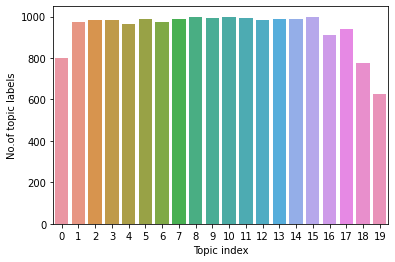

In [6]:
balance_check_graph(news_df.label) # The graph looks pretty balanced. 

### 1.2 reading/parsing Reuters news data

In [7]:
# working directory: the folder where the reuters-data folder is located 
news_data = []
for index in range(22):
    filename = f'reuters-data/reut2-{str(index).zfill(3)}.sgm'
    with open(filename, 'r', encoding='utf-8', errors='ignore') as infile:
        news_data.append(infile.read())

In [8]:
from bs4 import BeautifulSoup
import re 

result = []
total_counter = 0

for i in range(len(news_data)):
    bs = BeautifulSoup(news_data[i], 'html.parser')
    
    for topic_raw in bs.find_all('topics'):
        total_counter+=1
        topic = re.split('<[^<>]*>', str(topic_raw))
        topic = list(map(lambda x: x.strip(), topic))
        topic = list(filter(lambda x: x != '', topic))

        if len(topic) != 0: #I will only use the data that contains topic
            try:
                body = topic_raw.find_next('body').get_text()
                topic_body_tuple = (topic, body)
                result.append(topic_body_tuple)
                
            except:
                pass
            
print('parsing completed!')
print('Total number of data: ', total_counter)
print('Total number of data for the classification: ', len(result))

parsing completed!
Total number of data:  21578
Total number of data for the classification:  11366


According to above cell [18] , Reuters news data has too many texts which lack labels. After getting rid of the data without labels, the total number of data reduced almost in half. 

In [9]:
from collections import Counter

total_label = []
for r in result:
    total_label.append(r[0])
total_label = sum(total_label, [])
label_classes = Counter(total_label)

print("The size of the label classes: ", len(label_classes))
print("Total number of label occurence: ", sum(label_classes.values()))
print("Total number of label occurence for top 45 classes: ", sum(list(label_classes.values())[:45]))

The size of the label classes:  120
Total number of label occurence:  14301
Total number of label occurence for top 45 classes:  12847


I will use top 45 topics which consists of most of the data out of 120 topics. Total number of label occurence among whole dataset was 12301. It exceeds the total number of data, 
because it is sometimes multi-labeled. Total number of label occurence for top 45 classes was 12847, 
which I assumed there is no critical information loss. 

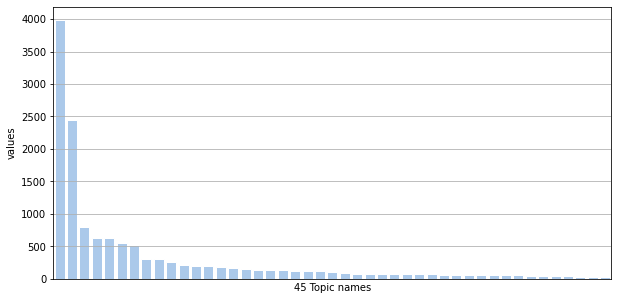

In [10]:
# To check whether the Reuters newsdata is well balanced or not

balance_check = label_classes.most_common(45)
names, values = zip(*balance_check)

df = pd.DataFrame({'names' : names})
df1 = pd.DataFrame({'values': values})
df1 = pd.concat([df, df1], axis=1)

fig, ax = plt.subplots(figsize = ( 10, 5 ))
ax.grid()

sns.set_color_codes('pastel')
g = sns.barplot(x='names', y='values', data=df1, color='b', edgecolor='w')
ax.set_xlabel('45 Topic names')
ax.set_xticks([])
plt.show()

According to the above graph, Reuters news data is not distributed in balance. I will, later, try 'Complement Naive Bayes' classifier which is particularly suited for imbalanced data sets. 

In [11]:
label_classes_ = [] # top 45 topics 
for i in label_classes.most_common(45):
    label_classes_.append(i[0])

In [12]:
delete_news = []
for r in result:
    for topic in r[0]:
        if topic not in label_classes_:
            delete_news.append(r)

result_final = [r for r in result if r not in delete_news]
print("Total number of data for 45 topics: ", len(result_final))

Total number of data for 45 topics:  10821


In [13]:
# I changed the data into the dataframe to ease the text preprocessing. 

reuter_df = pd.DataFrame(result_final)
reuter_df.columns = ["label", "text"]
reuter_df.head() # This is how the data looks like before cleaning texts. 

,label,text
0,[cocoa],Showers continued throughout the week in\nthe ...
1,[earn],Champion Products Inc said its\nboard of direc...
2,[acq],Computer Terminal Systems Inc said\nit has com...
3,[earn],"Shr 34 cts vs 1.19 dlrs\n Net 807,000 vs 2,..."
4,"[earn, acq]","Ohio Mattress Co said its first\nquarter, endi..."


As seen above, there are various multi-labeled data in the dataset, such as the 4th index row. 

In [14]:
# reuter data preprocessing & tokenization

import nltk
from nltk import word_tokenize

reuter_df['tokenized_sents'] = reuter_df.apply(lambda row: nltk.word_tokenize(row['text'].lower()), axis=1)
reuter_df['tokenized_sents'] = reuter_df['tokenized_sents'].apply(lambda words: [word for word in words if word not in stop_words])
reuter_df['tokenized_sents'] = reuter_df['tokenized_sents'].apply(lambda words: [word for word in words if word.isalpha()])
reuter_df['clean_text'] = reuter_df['tokenized_sents'].apply(lambda x: ' '.join(item for item in x))

In [15]:
# Example of cleaned text and its labels  
reuter_df[['label', 'clean_text']].head()

,label,clean_text
0,[cocoa],showers continued throughout week bahia cocoa ...
1,[earn],champion products inc said board directors app...
2,[acq],computer terminal systems inc said completed s...
3,[earn],shr cts vs dlrs net vs assets mln vs mln depos...
4,"[earn, acq]",ohio mattress co said first quarter ending feb...


### 1.2.1 Binarization for multi-labeled topics in Reuter data 

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(reuter_df['label'])
y_raw_rt = mlb.transform(reuter_df['label'])

assert len(mlb.classes_) == len(label_classes_)

In [17]:
mlb.classes_

array(['acq', 'alum', 'barley', 'bop', 'carcass', 'cocoa', 'coffee',
       'copper', 'corn', 'cotton', 'cpi', 'crude', 'dlr', 'earn', 'gas',
       'gnp', 'gold', 'grain', 'interest', 'ipi', 'iron-steel', 'jobs',
       'lead', 'livestock', 'meal-feed', 'money-fx', 'money-supply',
       'nat-gas', 'oilseed', 'palm-oil', 'pet-chem', 'rapeseed',
       'reserves', 'rice', 'rubber', 'ship', 'silver', 'sorghum',
       'soybean', 'sugar', 'trade', 'veg-oil', 'wheat', 'yen', 'zinc'],
      dtype=object)

# 2. Spliting dataset into train/test data

Here is the short description of the variable names for the _X_raw, y_raw_ for both sklearn and reuters news data

- __For the 20 news group data__
    1. X_raw data : news_df['clean_text'] => variable name: X_raw_sk
    2. y_raw data : news_df['label'] => variable name: y_raw_sk


- __For the Reuters news data__
    1. X_raw data : reuter_df['clean_text'] => variable name: X_raw_rt
    2. y_raw data : y_raw_rt (It is a binarized data with a np.array matrix form) => variable name: y_raw_rt

In [18]:
X_raw_sk = news_df['clean_text'] # 20 newsgroup X raw
y_raw_sk = news_df['label'] # 20 newsgroup y_raw
X_raw_rt = reuter_df['clean_text'] # reuters news X raw 

In [19]:
from sklearn.model_selection import train_test_split

def data_split(X, y):
    X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_raw_train, X_raw_test, y_raw_train, y_raw_test

In [20]:
# data split
x_train_sk, x_test_sk, y_train_sk, y_test_sk = data_split(X_raw_sk, y_raw_sk) # newsgroup 20
x_train_rt, x_test_rt, y_train_rt, y_test_rt = data_split(X_raw_rt, y_raw_rt) # reuters

In [21]:
assert(len(x_train_sk) == len(y_train_sk))
assert(len(x_train_rt) == len(y_train_rt))
assert(len(x_test_sk) == len(y_test_sk))
assert(len(x_test_rt) == len(y_test_rt))

# 3.Feature optimization 

Before training the model, I will explore various parameters of vectorizers to find the optimal feature vectorization. \
I tried exploring vectorizer's parameters using sklearn's Pipeline and Gridsearch. 
\
The baseline classifier is _Linear SVM: SGD Classifier._

    - ngram range : from unigram to trigram 
    - normalization : l1 and l2
    - sublinear tf scaling: True or False 

In [22]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier

cv_vectorizer = ('countvec', CountVectorizer())
idf_vectorizer = ('tfidfvec', TfidfVectorizer())

model_sk = ('sgd', SGDClassifier())
model_rt = ('sgd', OneVsRestClassifier(SGDClassifier()))

cv_pipe_sk = Pipeline([cv_vectorizer, model_sk])
idf_pipe_sk = Pipeline([idf_vectorizer, model_sk])

cv_pipe_rt = Pipeline([cv_vectorizer, model_rt])
idf_pipe_rt = Pipeline([idf_vectorizer, model_rt])

# 20 news group data
cv_pipe_sk.fit(x_train_sk, y_train_sk)
idf_pipe_sk.fit(x_train_sk, y_train_sk)

# Reuter news group 
cv_pipe_rt.fit(x_train_rt, y_train_rt)
idf_pipe_rt.fit(x_train_rt, y_train_rt)

#parameter setting
ngram = [(1,1), (1,2), (1,3)]
norm = ['l1', 'l2']
sublinear_tf = [True, False]
params_cv = {'countvec__ngram_range': ngram}
params_idf = {'tfidfvec__ngram_range': ngram,
              'tfidfvec__sublinear_tf' : sublinear_tf,
              'tfidfvec__norm': norm}

# saving score/best parameter 
train_score = []
test_score = []
optimal_params = []

#Count Vectorizer for 20 newsgroup 
print('model fitting started for 20 newsgroups with Count vectorizer.')
grid = GridSearchCV(cv_pipe_sk, param_grid=params_cv, cv=3)
grid.fit(x_train_sk, y_train_sk)
train_score.append(round(grid.best_score_, 4))
test_score.append(round(grid.score(x_test_sk, y_test_sk), 4))
optimal_params.append(grid.best_params_)

# tfidf Vectorizer for 20 newsgroup 
print('model fitting started for 20 newsgroups with tfidf vectorizer.')
grid = GridSearchCV(idf_pipe_sk, param_grid=params_idf, cv=3)
grid.fit(x_train_sk, y_train_sk)
train_score.append(round(grid.best_score_, 4))
test_score.append(round(grid.score(x_test_sk, y_test_sk), 4))
optimal_params.append(grid.best_params_)

# Count Vectorizer for Reuter newsgroup 
print('model fitting started for Reuters newsgroup with Count vectorizer.')
grid = GridSearchCV(cv_pipe_rt, param_grid=params_cv, cv=3)
grid.fit(x_train_rt, y_train_rt)
train_score.append(round(grid.best_score_, 4))
test_score.append(round(grid.score(x_test_rt, y_test_rt), 4))
optimal_params.append(grid.best_params_)

# Tfidf Vectorizer for Reuter newsgroup 
print('model fitting started for Reuters newsgroup with tfidf vectorizer.')
grid = GridSearchCV(idf_pipe_rt, param_grid=params_idf, cv=3)
grid.fit(x_train_rt, y_train_rt)
train_score.append(round(grid.best_score_, 4))
test_score.append(round(grid.score(x_test_rt, y_test_rt), 4))
optimal_params.append(grid.best_params_)

model fitting started for 20 newsgroups with Count vectorizer.
model fitting started for 20 newsgroups with tfidf vectorizer.
model fitting started for Reuters newsgroup with Count vectorizer.
model fitting started for Reuters newsgroup with tfidf vectorizer.
Wall time: 9min 50s


In [23]:
# 20 Newsgroups 
news_20_df = pd.DataFrame({'CountVec':[test_score[0], optimal_params[0].values()],
                           'Tf-idf':[test_score[1], optimal_params[1].values()]}, 
                           index=['test_score', 'optimal params'])

news_20_df

,CountVec,Tf-idf
test_score,0.8177,0.8907
optimal params,"((1, 2))","((1, 2), l2, True)"


For the 20 news groups, Tf-idf showed better results in both train and test dataset. Uni-bigram showed the best results for both vectorizers. \
For the Tf-idf vectorizers, Applying sublinear tf scaling and l2 normalization worked better.      

In [24]:
# Reuters news data  
reuters_df = pd.DataFrame({'CountVec':[test_score[2], optimal_params[2].values()],
                           'Tf-idf':[test_score[3], optimal_params[3].values()]}, 
                           index=['test_score', 'optimal params'])

reuters_df

,CountVec,Tf-idf
test_score,0.7136,0.7709
optimal params,"((1, 3))","((1, 1), l2, True)"


Tf-idf vectorizer showed the better result for the Reuters news data, which is the same result as the 20 newsgroup data. Unlike 20 news data, tf-idf's unigram was better parameter for the model training. For the countvectorizer, ngram range of uni- to tri-gram was optimal. 
Compared to the 20 newsgroup data, Reuters news group data showed lower accuracy. 

### 4. Vectorization using Tf-idf vectorizer

As shown on the feature selection optimization above, tf-idf vectorizer showed the best result. 
For the 20 news group data, I will use the ngram range of uni to trigram.  \
For the Reuters news data, only unigram will be used for the model fitting. 
For the both datasets, L2 normalization and sublinear tf scaling will be used. 

### 4.1 20 Newsgroup data 

In [25]:
vec_sk = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), norm='l2')

train_features_sk = vec_sk.fit_transform(x_train_sk)
test_features_sk = vec_sk.transform(x_test_sk)

print(f'TFIDF model:> \n Train features shape: \t {train_features_sk.shape},\n Test features shape: \t {test_features_sk.shape}')

TFIDF model:> 
 Train features shape: 	 (15072, 1072379),
 Test features shape: 	 (3768, 1072379)


### 4.2 Reuters news data

In [26]:
vec_rt = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,1), norm='l2')

train_features_rt = vec_rt.fit_transform(x_train_rt)
test_features_rt = vec_rt.transform(x_test_rt)

print(f'TFIDF model:> \n Train features shape: \t {train_features_rt.shape},\n Test features shape: \t {test_features_rt.shape}')

TFIDF model:> 
 Train features shape: 	 (8656, 23099),
 Test features shape: 	 (2165, 23099)


# 5. Train the model

    1. Non-probablistic model : SGDClassifier with hinge loss
    2. Probablistic model : sklearn.naive_bayes.ComplementNB 

### 5.1 Building a pipeline 

In [40]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Nonprobablistic classifier pipe
# 20 news
clf_np_sk = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), norm='l2', sublinear_tf=True)),
    ('clf', SGDClassifier('hinge'))
])
# Reuter
clf_np_rt = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), norm='l2', sublinear_tf=True)),
    ('clf', OneVsRestClassifier(SGDClassifier('hinge')))
])

# Probablistic classifier pipe
# 20 news
clf_p_sk = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), norm='l2', sublinear_tf=True)),
    ('clf', ComplementNB())
])
# Reuter
clf_p_rt = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), norm='l2', sublinear_tf=True)),
    ('clf', OneVsRestClassifier(ComplementNB()))
])


clf_np_sk.fit(x_train_sk, y_train_sk)
clf_p_sk.fit(x_train_sk, y_train_sk)
clf_np_rt.fit(x_train_rt, y_train_rt)
clf_p_rt.fit(x_train_rt, y_train_rt)

Pipeline(steps=[('vect', TfidfVectorizer(sublinear_tf=True)),
                ('clf', OneVsRestClassifier(estimator=ComplementNB()))])

# 6. Evaluation of the performance on the test set 

### 6.1 Accuracy

In [41]:
# Accuracy on the train data 
from sklearn.metrics import accuracy_score, classification_report

t_np_sk = clf_np_sk.predict(x_train_sk)
t_p_sk = clf_p_sk.predict(x_train_sk)
t_np_rt = clf_np_rt.predict(x_train_rt)
t_p_rt = clf_p_rt.predict(x_train_rt)

print(f'Accuracy on 20 newsgroup data with SGD Classifier: {np.round(accuracy_score(t_np_sk, y_train_sk), 2)*100}%')
print(f'Accuracy on 20 newsgroup data with Complement NB Classifier: {np.round(accuracy_score(t_p_sk, y_train_sk), 2) * 100}%')
print(f'Accuracy on Reuters news data with SGD Classifier: {np.round(accuracy_score(t_np_rt, y_train_rt), 2) * 100}%')
print(f'Accuracy on Reuters news data with Complement NB Classifier: {np.round(accuracy_score(t_p_rt, y_train_rt), 2) * 100}%')

Accuracy on 20 newsgroup data with SGD Classifier: 99.0%
Accuracy on 20 newsgroup data with Complement NB Classifier: 99.0%
Accuracy on Reuters news data with SGD Classifier: 90.0%
Accuracy on Reuters news data with Complement NB Classifier: 57.99999999999999%


In [42]:
# Accuracy on the test data 

p_np_sk = clf_np_sk.predict(x_test_sk)
p_p_sk = clf_p_sk.predict(x_test_sk)
p_np_rt = clf_np_rt.predict(x_test_rt)
p_p_rt = clf_p_rt.predict(x_test_rt)

print(f'Accuracy on 20 newsgroup data with SGD Classifier: {np.round(accuracy_score(p_np_sk, y_test_sk), 2)*100}%')
print(f'Accuracy on 20 newsgroup data with Complement NB Classifier: {np.round(accuracy_score(p_p_sk, y_test_sk), 2) * 100}%')
print(f'Accuracy on Reuters news data with SGD Classifier: {np.round(accuracy_score(p_np_rt, y_test_rt), 2) * 100}%')
print(f'Accuracy on Reuters news data with Complement NB Classifier: {np.round(accuracy_score(p_p_rt, y_test_rt), 2) * 100}%')

Accuracy on 20 newsgroup data with SGD Classifier: 89.0%
Accuracy on 20 newsgroup data with Complement NB Classifier: 90.0%
Accuracy on Reuters news data with SGD Classifier: 77.0%
Accuracy on Reuters news data with Complement NB Classifier: 53.0%


__Analysis__ 

Based on test accuracy, 20 newsgroup data using a probablistic classifier acheived the highest score (90%). The 20 newsgroups data from sklearn had slightly unbalanced data compared to Reuters news data. Complement NB classifier, which is generally used for the imbalanced data set, worked well on the data, but didn't work well on the highly imbalanced data, like Reuters news barely reaching over 50%. The SGD Classifier, however, performed pretty good in general regardless of the data balance or any other circumstances. 

Overfitting: Reuters news data adapted to the SGD model while training process, reaching to 90% accuracy. However, when it was tested on the test data, the accuracy dropped to 77%, which is a bad sign of the overfitting. Reuters data using Complement NB worked poorly both on train/test data set.

Since the Complement NB Classifier worked so poorly on Reuters data, I will try Multinomial NB as a probabilistic classifier. The reason why I chose this classifier is because multinomial Naive Bayes classifier is suitable for classification with discrete features in text classification. 

In [30]:
from sklearn.naive_bayes import MultinomialNB

# Nonprobablistic classifier pipe
# 20 news
clf_np_sk = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), norm='l2', sublinear_tf=True)),
    ('clf', SGDClassifier('hinge'))
])
# Reuter
clf_np_rt = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), norm='l2', sublinear_tf=True)),
    ('clf', OneVsRestClassifier(SGDClassifier('hinge')))
])

# Probablistic classifier pipe
# 20 news
clf_p_sk = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), norm='l2', sublinear_tf=True)),
    ('clf', MultinomialNB())
])
# Reuter
clf_p_rt = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), norm='l2', sublinear_tf=True)),
    ('clf', OneVsRestClassifier(MultinomialNB()))
])


clf_np_sk.fit(x_train_sk, y_train_sk)
clf_p_sk.fit(x_train_sk, y_train_sk)
clf_np_rt.fit(x_train_rt, y_train_rt)
clf_p_rt.fit(x_train_rt, y_train_rt)

Pipeline(steps=[('vect', TfidfVectorizer(sublinear_tf=True)),
                ('clf', OneVsRestClassifier(estimator=MultinomialNB()))])

In [31]:
# Accuracy on the train data 
from sklearn.metrics import accuracy_score, classification_report

t_np_sk = clf_np_sk.predict(x_train_sk)
t_p_sk = clf_p_sk.predict(x_train_sk)
t_np_rt = clf_np_rt.predict(x_train_rt)
t_p_rt = clf_p_rt.predict(x_train_rt)

print(f'Accuracy on 20 newsgroup data with SGD Classifier: {np.round(accuracy_score(t_np_sk, y_train_sk), 2)*100}%')
print(f'Accuracy on 20 newsgroup data with Multinomial NB Classifier: {np.round(accuracy_score(t_p_sk, y_train_sk), 2) * 100}%')
print(f'Accuracy on Reuters news data with SGD Classifier: {np.round(accuracy_score(t_np_rt, y_train_rt), 2) * 100}%')
print(f'Accuracy on Reuters news data with Multinomial NB Classifier: {np.round(accuracy_score(t_p_rt, y_train_rt), 2) * 100}%')

Accuracy on 20 newsgroup data with SGD Classifier: 99.0%
Accuracy on 20 newsgroup data with Multinomial NB Classifier: 98.0%
Accuracy on Reuters news data with SGD Classifier: 90.0%
Accuracy on Reuters news data with Multinomial NB Classifier: 49.0%


In [32]:
# Accuracy on the test data 

p_np_sk = clf_np_sk.predict(x_test_sk)
p_p_sk = clf_p_sk.predict(x_test_sk)
p_np_rt = clf_np_rt.predict(x_test_rt)
p_p_rt = clf_p_rt.predict(x_test_rt)

print(f'Accuracy on 20 newsgroup data with SGD Classifier: {np.round(accuracy_score(p_np_sk, y_test_sk), 2)*100}%')
print(f'Accuracy on 20 newsgroup data with Multinomial NB Classifier: {np.round(accuracy_score(p_p_sk, y_test_sk), 2) * 100}%')
print(f'Accuracy on Reuters news data with SGD Classifier: {np.round(accuracy_score(p_np_rt, y_test_rt), 2) * 100}%')
print(f'Accuracy on Reuters news data with Multinomial NB Classifier: {np.round(accuracy_score(p_p_rt, y_test_rt), 2) * 100}%')

Accuracy on 20 newsgroup data with SGD Classifier: 89.0%
Accuracy on 20 newsgroup data with Multinomial NB Classifier: 86.0%
Accuracy on Reuters news data with SGD Classifier: 77.0%
Accuracy on Reuters news data with Multinomial NB Classifier: 44.0%


__Model Analysis__

Overall, SGD Classifier showed stable results on both 20 newsgroups and Reuters news data in a fast speed. For the probabilistic classifier, however, showed very low accuracy on Reuters data, when the data consists of multi-labeled y and number of topics are large. I tried two probabilistic classifier to get the highest accuracy. As a result, Complement Naive Bayes classifier showed slightly better result than Multinomial NB. I'm going to stick with the Complement NB classifier from now on.    

In the next step, I will analyze the precision/recall and f1 score and try various parameter tuning using Gridsearch to reach to the highest accuracy rate. 

### 6.2 Precision/recall/f1-score

__20 newsgroup with non probablistic classifier : SGD__

<AxesSubplot:>

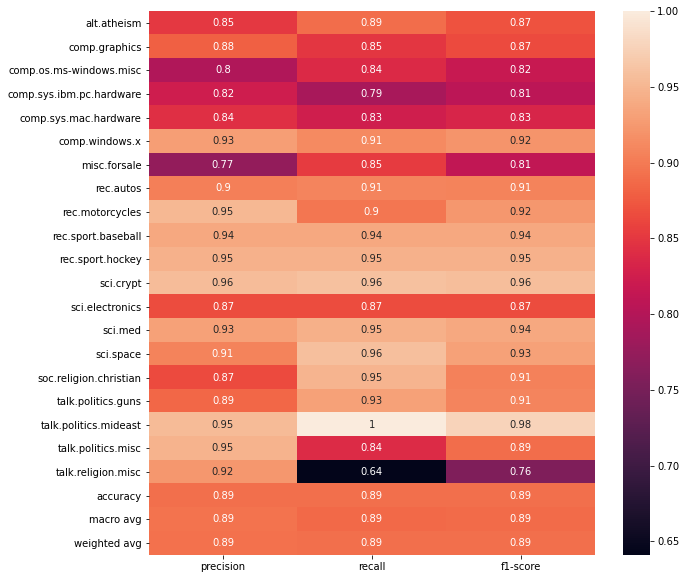

In [33]:
import seaborn as sns
sgd_20news_np = classification_report(y_test_sk, p_np_sk, target_names=newsgroups.target_names, output_dict=True)
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(pd.DataFrame(sgd_20news_np).iloc[:-1, :].T, annot=True)

__20 newsgroup with probablistic classifier: Complement NB Classifier__

<AxesSubplot:>

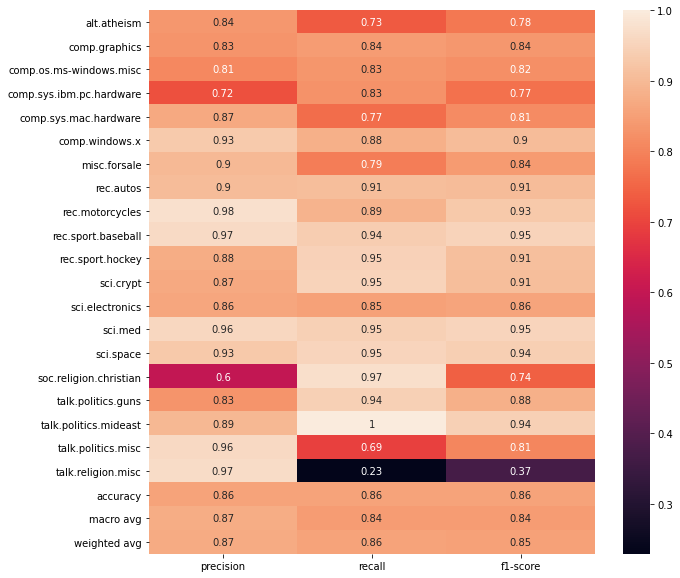

In [34]:
cnb_20news_p = classification_report(y_test_sk, p_p_sk, target_names=newsgroups.target_names, output_dict=True)
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(pd.DataFrame(cnb_20news_p).iloc[:-1, :].T, annot=True)

__Reuters news with nonprobablistic classifier: SGD__

<AxesSubplot:>

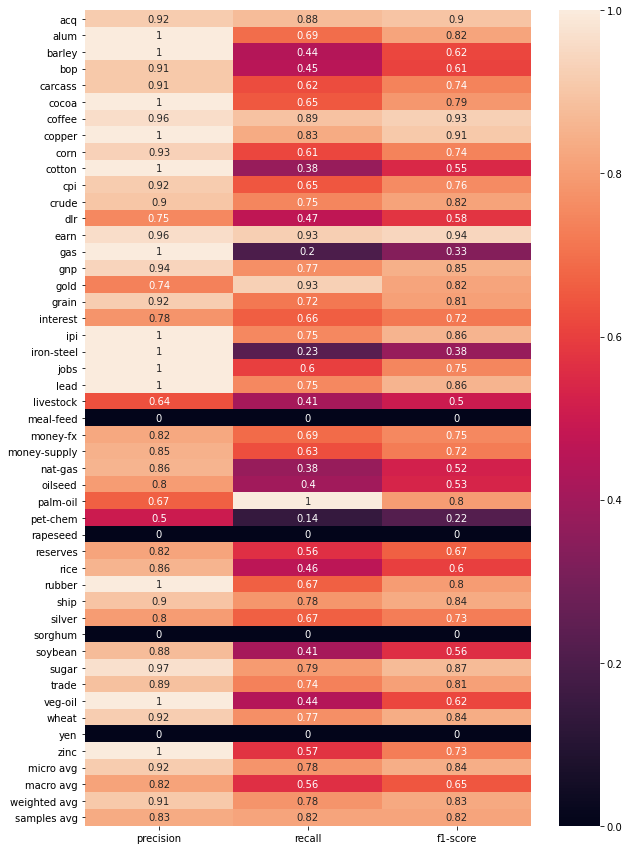

In [35]:
sgd_reuters_np = classification_report(y_test_rt, p_np_rt, zero_division=0, target_names=mlb.classes_, output_dict=True)
fig, ax = plt.subplots(figsize=(10,15))   
sns.heatmap(pd.DataFrame(sgd_reuters_np).iloc[:-1, :].T, annot=True)

__Reuters news with probablistic classifier: Complement NB classifier__

<AxesSubplot:>

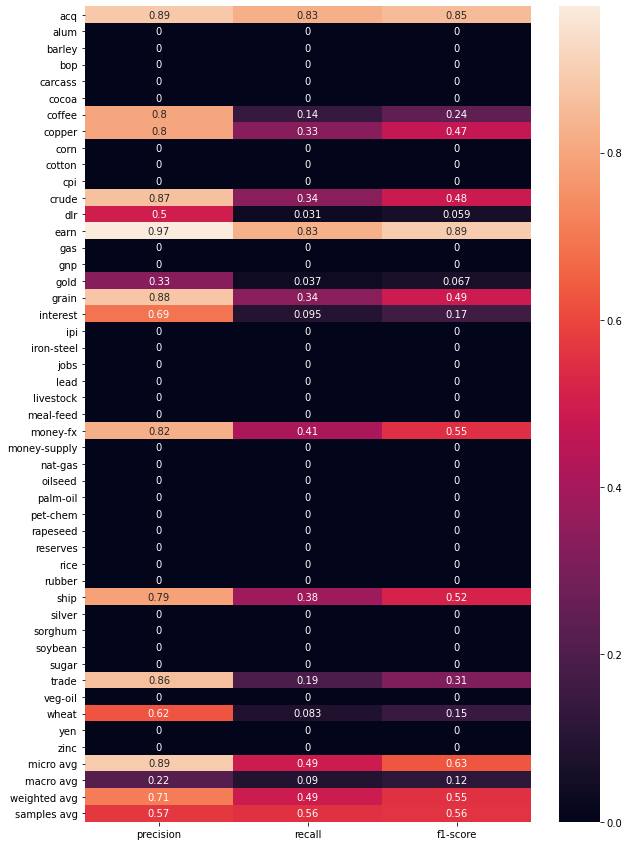

In [43]:
cnb_reuters_p = classification_report(y_test_rt, p_p_rt, zero_division=0, target_names=mlb.classes_, output_dict=True)
fig, ax = plt.subplots(figsize=(10,15))   
sns.heatmap(pd.DataFrame(cnb_reuters_p).iloc[:-1, :].T, annot=True)

### classification report analysis 

1. __20 newsgroups dataset__ \
    The classification result of 20 newsgroups data shows that the precision and recall have the same value of 90%. It means that high number of texts were correctly predicted given all the predicted topics. 
    


2. __Reuters dataset__ \
    Since the data is highly imbalanced, I'm going to analyze the weighted avg's precision/recall/f1-score of the SGD classifier and Complement NB classifier. SGD classifier showed precision- 91% , recall- 78% , and f1-score- 83%. It means that large number of topics labelled by the system were actually the true topic. Recall, however, dropped down till 78%, which means that out of total actual topics, only 78% of the data were classified into correct topics. F1-score, a weighted harmonic mean of precision and recall, was 83%, which means pretty good balance of precision and recall. Complement NB classifier showed only 49% recall. It means that the classifier's ability to find all correct instances per class was very low, not even reaching 50%. In the next stage, I'm going to explore various parameters with only SGD classifier to make the classifier's accuracy/precision/recall higher than the baseline. 

# 7. Hyperparameter tuning using grid search

In [37]:
%%time

tfidf_sk = ('tfidfvec', TfidfVectorizer(ngram_range=(1,2), norm='l2', sublinear_tf=True))

model_sk = ('sgd', SGDClassifier(max_iter=5000))

# 20 news group data
pipe_sk = Pipeline([tfidf_sk, model_sk])
pipe_sk.fit(x_train_sk, y_train_sk)

#parameter setting
loss = ['hinge', 'squared_hinge']
penalty = ['l1', 'l2']
alpha = [0.0001, 0.001, 0.01]
class_weight = ['balanced', None]

params_idf = {'sgd__loss': loss,
              'sgd__penalty' : penalty,
              'sgd__alpha': alpha,
              'sgd__class_weight' : class_weight}

# saving score/best parameter 
train_score = []
test_score = []
optimal_params = []

# Hyperparameter tuning for 20 newsgroups 
print('SGD Hyperparameter tuning started for 20 newsgroups.')
grid = GridSearchCV(pipe_sk, param_grid=params_idf, cv=3, scoring='f1_micro')
grid.fit(x_train_sk, y_train_sk)
train_score.append(round(grid.best_score_, 4))
test_score.append(round(grid.score(x_test_sk, y_test_sk), 4))
optimal_params.append(grid.best_params_)

SGD Hyperparameter tuning started for 20 newsgroups.
Wall time: 12min 4s


In [38]:
print(f'optimal parameter set : {optimal_params[0]}')

optimal parameter set : {'sgd__alpha': 0.0001, 'sgd__class_weight': 'balanced', 'sgd__loss': 'squared_hinge', 'sgd__penalty': 'l2'}


In [39]:
# Hyperparameter tuning for Reuter newsgroup 

model_to_set = OneVsRestClassifier(SGDClassifier(max_iter=5000))

#parameter setting
loss = ['hinge', 'squared_hinge']
alpha = [0.0001, 0.001, 0.01]
class_weight = ['balanced', None]

params_idf_rt = {'estimator__loss': loss,
                 'estimator__alpha': alpha,
                 'estimator__class_weight' : class_weight}


print('SGD Hyperparameter tuning started for Reuters newsgroup.')
grid = GridSearchCV(model_to_set, param_grid=params_idf_rt, scoring='f1_weighted')
grid.fit(train_features_rt, y_train_rt)
train_score.append(round(grid.best_score_, 4))
test_score.append(round(grid.score(test_features_rt, y_test_rt), 4))
optimal_params.append(grid.best_params_)

SGD Hyperparameter tuning started for Reuters newsgroup.


C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\wk789\Miniconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


### Hyperparameter tuning

For the 20 newsgroups data, It performed better to use squared hinge loss. Reuters data, on the othe hand, showed better performance when the default hinge loss was used for the loss function. Both of the data showed higher level of performance when the preset for the class_weight was set to "balanced", which uses the values of _y_ to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).  

# 8. Final result 

In [48]:
# Nonprobablistic classifier pipe
# 20 news
clf_np_sk_final = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), norm='l2', sublinear_tf=True)),
    ('clf', SGDClassifier(loss='squared_hinge', class_weight='balanced'))
])
# Reuter
clf_np_rt_final = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), norm='l2', sublinear_tf=True)),
    ('clf', OneVsRestClassifier(SGDClassifier(loss='hinge', class_weight='balanced')))
])

clf_np_sk_final.fit(x_train_sk, y_train_sk)
clf_np_rt_final.fit(x_train_rt, y_train_rt)


Pipeline(steps=[('vect', TfidfVectorizer(sublinear_tf=True)),
                ('clf',
                 OneVsRestClassifier(estimator=SGDClassifier(class_weight='balanced')))])

In [49]:
# Accuracy on training data

t_np_sk_final = clf_np_sk_final.predict(x_train_sk)
t_np_rt_final = clf_np_rt_final.predict(x_train_rt)

print(f'Accuracy on 20 newsgroup data with tuned SGD Classifier: {np.round(accuracy_score(t_np_sk_final, y_train_sk), 2)*100}%')
print(f'Accuracy on Reuters news data with tuned SGD Classifier: {np.round(accuracy_score(t_np_rt_final, y_train_rt), 2) * 100}%')


Accuracy on 20 newsgroup data with tuned SGD Classifier: 100.0%
Accuracy on Reuters news data with tuned SGD Classifier: 83.0%


In [50]:
# Accuracy on the test data 

p_np_sk_final = clf_np_sk_final.predict(x_test_sk)
p_np_rt_final = clf_np_rt_final.predict(x_test_rt)

print(f'Accuracy on 20 newsgroup data with SGD Classifier: {np.round(accuracy_score(p_np_sk_final, y_test_sk), 2)*100}%')
print(f'Accuracy on Reuters news data with SGD Classifier: {np.round(accuracy_score(p_np_rt_final, y_test_rt), 2) * 100}%')


Accuracy on 20 newsgroup data with SGD Classifier: 90.0%
Accuracy on Reuters news data with SGD Classifier: 71.0%


When I experimented with 20 newsgroups' training data, it showed 100% accuracy, even though it dropped to 90% when I put in the test data. The classifier performed slightly better with tuned hyperparameters on 20 newsgroups data. However, Reuters news data did not improve up to my expectation. The reason I presumed was that the max iteration was not enough for the data and the dataset was multi-labeled and imbalanced data compared to the 20 newsgroups data, which was already tuned by sklearn. 